In [81]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import numpy as np
import jax.numpy as jnp

import argparse
import os
import signal
import sys
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import itertools
import time

#-----------------------------------------------------
# Imports
import functools
import jax
import jax.tree_util as tree


from jaxopt import OptaxSolver
import pickle
from functools import partial
from jax import lax
import diffrax
from typing import Any, Callable, Dict, List, Optional, Tuple
import equinox as eqx
log_folder="runs"
# jax.config.update('jax_platform_name', 'cpu')

from torch.utils.tensorboard import SummaryWriter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
# -------------------------------------------------------
## Regular Linear layer in equinox
from libs.model import *
from libs.utils import *
from libs.trainer import *


def return_data(hbaromega_choose, plot=False):
    X = np.load("data/processed_extrapolation.npy", allow_pickle=True)
    
    if plot:
        ETr = X[()]["data"][:, 1:]
        h_omega = X[()]["data"][:, 0]
        N_Max = X[()]["Nmax"].reshape([-1])
        ts_ = np.concatenate([N_Max + j * 18 for j in range(repeat + 1)], axis=0)
        ts_ = np.vstack(ts_).reshape([-1, 1])
    else:
        ETr = X[()]["data"][:hbaromega_choose, 1:]
        h_omega = X[()]["data"][:hbaromega_choose, 0]
        N_Max = X[()]["Nmax"].reshape([-1])
        ts_ = np.concatenate([N_Max + j * 18 for j in range(repeat + 1)], axis=0)
        ts_ = np.vstack(ts_).reshape([-1, 1])


    print("X", ETr.shape, "N_Max", ts_.shape, "hbarOmega", h_omega.shape)
    # --------------------------------------------
    # Normalizing factors
    scale_gs = -32.5
    scale_ho = 50
    scale_Nmax = np.max(ts_)

    # --------------------------------------------
    # Normalize the dataset for efficiency
    ts_ = ts_ / scale_Nmax
    x1 = ETr / scale_gs
    x2 = h_omega / scale_ho
    # --------------------------------------------
    # Reverse Normalization
    # print(np.max(x1), np.max(x2), scale_gs, scale_ho, scale_Nmax )
    # x1=x1*scale_gs
    # x2=x2*scale_ho
    # t=t*scale_Nmax
    x2 = jnp.expand_dims(jnp.expand_dims(x2, 1), 1)
    x1 = jnp.expand_dims(x1, 2)
    x2 = jnp.repeat(x2, x1.shape[1], axis=1)
    x = jnp.concatenate([x1, x2], axis=2)

    return ts_, x, scale_gs, scale_ho, scale_Nmax


def main(
    ts_,
    x,
    trainer,
    model,
    model_path,
    model_num,
    iterations,
    factor,
    init_step,
    save_iter=200,
    print_iter=200,
):
    params, static = eqx.partition(model, eqx.is_array)
    # -----------------------------------------------------------
    # initialize the loss function
    # -----------------------------------------------------------
    # initialize the optimizer
    # optim = OptaxSolver(
    #     opt=optax.nadamw(1e-05),\
    #     fun=trainer.return_loss_grad,\
    #     value_and_grad=True,\
    #     has_aux=True,\
    #     jit=False
    # )
    
    # import jaxopt
    # optim = jaxopt.NonlinearCG(fun=trainer.return_loss_grad,
    #     value_and_grad=True,\
    #     has_aux=True,\
    #     jit=False,\
    #     unroll=False
    #     # linesearch='backtracking',\
    #     # linesearch_init='current',\
    # )
    optim = optax.yogi(1e-05)
    optim__path = 'load__optimize.pkl'
    if os.path.exists(optim__path):
        epoch, opt_state, optim = load_opt_state_from_pkl(optim__path)
        print(f"loaded model {optim__path}")


    # t = np.linspace(0, max(ts_), 100)
    # optim = optax.scale_by_lbfgs()
    # -----------------------------------------------------------
    params = trainer.train__EUC__(
        (ts_, x, init_step, N_max_constraints, factor, model_num),
        params,
        static,
        optim,
        model_path=model_path,
        n_iter=iterations,
        save_iter=save_iter,
        print_iter=print_iter,
    )
    model = eqx.combine(params, static)
    return trainer, model



# ----------------------------------------------------------------
# The plotting
def generate_plot_hbar_omega(filename, model_name, model_list, x):
    print("plotting="+filename)
    # -----------------------------------------------
    import seaborn as sns

    sns.color_palette("bright")
    large = 20
    med = 18
    small = 16
    marker_size = 1.01
    lw = 0.1
    inten = 0.4

    def cm2inch(value):
        return value / 2.54

    COLOR = "darkslategray"
    params = {
        "axes.titlesize":  med,
        "legend.fontsize": med,
        "figure.figsize": (cm2inch(36), cm2inch(40)),
        "axes.labelsize": med,
        "axes.titlesize": large,
        "xtick.labelsize": med,
        "lines.markersize": marker_size,
        "ytick.labelsize": large,
        "figure.titlesize": large,
        "text.color": COLOR,
        "axes.labelcolor": COLOR,
        "axes.linewidth": 0.5,
        "xtick.color": COLOR,
        "ytick.color": COLOR,
    }
    colors = [
        "tab:blue",
        "tab:orange",
        "tab:green",
        "tab:red",
        "tab:purple",
        "tab:brown",
        "tab:pink",
        "tab:cyan",
        "dodgerblue",
        "violet",
        "orangered",
        "maroon",
        "darkorange",
        "burlywood",
        "greenyellow",
        "tab:gray",
        "black",
        "rosybrown",
        "lightseagreen",
        "teal",
        "aqua",
        "darkolivegreen",
    ]

    plt.rcParams.update(params)
    plt.rc("text", usetex=False)
    plt.figure()
    xhat=[]
    for i,num in enumerate(model_list):
        model_path = model_name+str(num)+".eqx"
        _, model = load_checkpoint(model_path, device="cpu")
        x0 = x[:, 0, :]
        t = ts_.reshape([-1])
        xhat.append(jax.vmap(model, in_axes=(None, 0))(t, x0))
       
    xhat = jnp.array(xhat)
    print(xhat.shape) 
    
    mean = jnp.mean(xhat, axis = 0)
    var  = jnp.sqrt(jnp.std(xhat, axis = 0))

    [
        plt.plot(
            x[:, i, 1] * scale_ho,
            x[:, i, 0] * scale_gs,
            linestyle="--",
            c=colors[i],
            label= str(   ts_[i]*scale_Nmax  ),
        )
        for i in range(10)
    ]
    [
        plt.errorbar(
            x[:, i, 1] * scale_ho,
            mean[:, i,  0] * scale_gs,
            yerr=var[:,i, 0],
            barsabove=True,
            ecolor=colors[i],
            label= str( ts_[i]*scale_Nmax ),
        )
        for i in range(10)
    ]
    
    plt.title("--  True; -  Predicted;  | Uncertainty")
    # plt.ylim([-31, -32.3])
    plt.xlim([0,25])
    plt.xlim([0, 68])
    plt.xlabel("$\\bar{h}\Omega$ (MeV)" )
    plt.ylabel("E (Ground State)")
    plt.grid(linestyle=":", linewidth=0.5)
    plt.legend(title="$NMax$",ncol=2, title_fontsize=large, loc='lower right', fancybox=True)
    # plt.savefig(filename, dpi=100)
    plt.show()
    plt.close()





def load_opt_state_from_pkl(pkl_path):
    with open(pkl_path, "wb") as p:
        params = pickle.loads(p)    
    epoch = params['epoch']
    opt_state = params['opt_state']       
    optimizer= params['optimizer']
    return epoch, opt_state, optimizer 


########################################################################################
def load_checkpoint(path, device="cpu"):
    # -----------------------------------------------------------
    trainer = Trainer()
    key = jax.random.PRNGKey(SEED)
    data_key, model_key, loader_key = jr.split(key, 3)

    # -----------------------------------------------------------
    # Initialize the model and load weights from a stored model
    # model = NeuralODE(data_size=2, width_size=128, depth=3, key=model_key)
    
    model = NeuralODE(data_size=2, width_size=64, depth=2, key=model_key)
    if os.path.exists(path):
        print(f"loaded model {path}")
        model = eqx.tree_deserialise_leaves(path, model)
    else:
        print("initialized model from scratch")
        eqx.tree_serialise_leaves(path, model)
    return trainer, model


In [92]:
jax.config.update("jax_enable_x64", False)
N_Max_points = 9
SEED = 5678
N_max_constraints = 20
hbaromega_choose = 8
repeat = 5
init_step=1    
dist_flag=1
list_models=[0,1,2,3]
    

ts_, x, scale_gs, scale_ho, scale_Nmax = return_data(hbaromega_choose)
model_path = (
    f"models/MLP__Extrapolation_vdist{hbaromega_choose}_{0}.eqx"
)

for i in range(x.shape[0]):
    print(x[i,0,1]*50, x[i, :,0]*-32.5)

X (8, 9) N_Max (54, 1) hbarOmega (8,)
8.0 [-16.57529  -22.07245  -25.76041  -28.266972 -29.85611  -30.82073
 -31.376461 -31.68395  -31.8479  ]
9.0 [-18.76554  -24.21102  -27.543169 -29.59771  -30.75878  -31.38568
 -31.70678  -31.866701 -31.94453 ]
10.0 [-20.62863  -25.904179 -28.81887  -30.44101  -31.25914  -31.65792
 -31.84509  -31.932991 -31.97466 ]
12.5 [-23.92152  -28.51269  -30.44546  -31.30909  -31.67491  -31.837399
 -31.91427  -31.95437  -31.977089]
15.000001 [-25.57763  -29.500269 -30.863821 -31.43441  -31.68819  -31.814241
 -31.884161 -31.926691 -31.95399 ]
17.5 [-26.05861  -29.57761  -30.78639  -31.32032  -31.58441  -31.73186
 -31.820639 -31.87769  -31.91603 ]
20.0 [-25.704401 -29.14255  -30.455051 -31.077961 -31.40886  -31.60391
 -31.72595  -31.8062   -31.86106 ]
22.5 [-24.672861 -28.36076  -29.931002 -30.721611 -31.16096  -31.42602
 -31.59523  -31.70796  -31.78564 ]


In [84]:
print(scale_gs, scale_ho, scale_Nmax)

-32.5 50 108


In [85]:
trainer, model = load_checkpoint(model_path, device="cpu")
x = x.astype(jnp.float64)
x0 = x[:, 0, :]
t = ts_.reshape([-1])
config = {
    "int_step": init_step,
    "N_Max_constraints": N_max_constraints,
    "dist_flag": dist_flag,
    "step": 0,
}
batch = (t, x0, x, config)
loss_val = []

for i,num in enumerate(list_models):
    model_name=f"models/MLP__Extrapolation_vdist{hbaromega_choose}_{num}.eqx"
    trainer, model = load_checkpoint(model_name, device="cpu")
    params, static = eqx.partition(model, eqx.is_array)
    loss_val.append( trainer.loss_fn_mse(params, static, batch) )

loss_val=jnp.array(loss_val)    
print(
    "The loss of the model is", jnp.mean(loss_val), jnp.sqrt(jnp.std(loss_val))
)

loaded model models/MLP__Extrapolation_vdist8_0.eqx
loaded model models/MLP__Extrapolation_vdist8_0.eqx
loaded model models/MLP__Extrapolation_vdist8_1.eqx
loaded model models/MLP__Extrapolation_vdist8_2.eqx
loaded model models/MLP__Extrapolation_vdist8_3.eqx
The loss of the model is 1066.3325 42.97594


/home/kraghavan/miniconda3/envs/jax__/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)


In [97]:
# ----------------------------------------------------------------
# The plotting
def generate_plot(filename, model_name, model_list, x, num_curves=8):
    print("plotting="+filename)
    # -----------------------------------------------
    import seaborn as sns
    sns.color_palette("bright")
    large = 18
    med = 16
    small = 14
    marker_size = 1.01
    lw = 0.1
    inten = 0.4
    scale_gs=-32.5
    
    def cm2inch(value):
        return value / 2.54
    COLOR = "darkslategray"
    params = {
        "axes.titlesize":  med,
        "legend.fontsize": med,
        "figure.figsize": (cm2inch(32), cm2inch(18)),
        "axes.labelsize": med,
        "axes.titlesize": large,
        "xtick.labelsize": med,
        "lines.markersize": marker_size,
        "ytick.labelsize": large,
        "figure.titlesize": large,
        "text.color": COLOR,
        "axes.labelcolor": COLOR,
        "axes.linewidth": 0.5,
        "xtick.color": COLOR,
        "ytick.color": COLOR,
    }
    colors = [
        "tab:blue",
        "tab:orange",
        "tab:green",
        "tab:red",
        "tab:purple",
        "tab:brown",
        "tab:pink",
        "tab:cyan",
        "dodgerblue",
        "violet",
        "orangered",
        "maroon",
        "darkorange",
        "burlywood",
        "greenyellow",
        "tab:gray",
        "black",
        "rosybrown",
        "lightseagreen",
        "teal",
        "aqua",
        "darkolivegreen",
    ]

    plt.rcParams.update(params)
    plt.rc("text", usetex=False)
    plt.figure(dpi=1000)
    xhat=[]
    for i,num in enumerate(model_list):
        model_path = model_name+str(num)+".eqx"
        _, model = load_checkpoint(model_path, device="cpu")
        x0 = x[:, 0, :]
        t = ts_.reshape([-1])
        xhat.append(jax.vmap(model, in_axes=(None, 0))(t, x0))
        
        
    xhat = jnp.array(xhat)
    mean = jnp.mean(xhat, axis = 0)
    var  =  jnp.std( mean[:,53, 0], axis = 0)**2
    print(mean[:,53,0])
    [
        plt.plot(
            ts_[0:9, :] * scale_Nmax,
            x[i, :, 0]*scale_gs,
            linestyle="--",
            c=colors[i],
            label= str(   round(x[i, 0, 1]*scale_ho,1)  ),
        )
        for i in range(num_curves)
    ]
    # [
    #     plt.errorbar(
    #         ts_ * scale_Nmax,
    #         mean[i, :, 0]*scale_gs,
    #         yerr=var,
    #         barsabove=True,
    #         ecolor=colors[i],
    #         label= str( round(x[i, 0, 1]*scale_ho, 2) ),
    #     )
    #     for i in range(num_curves)
    # ]
    plt.title("--  True; -  Predicted;  | Uncertainty | \n"+\
            '$E^{\\infty}_{GS}=$'+str(np.max(mean[:,53,0], axis=0)*scale_gs)+\
            ' ('+str( np.std(mean[:,53, 0], axis=0) )+')'
            )
    plt.ylim([0.97*scale_gs, 0.99*scale_gs])
    plt.xlabel("NMax")
    plt.ylabel("E (Ground State)")
    plt.grid(linestyle=":", linewidth=0.5)
    # plt.legend(title="$\\bar{h}\Omega$",ncol=2, title_fontsize=small, loc='lower right', fancybox=True)
    plt.show()
    # plt.savefig(filename, dpi=100)
    plt.close()



# ---------------------------------------------------------------
generate_plot(f"Figures/plot_hbaromega{hbaromega_choose}.pdf",\
            f"models/MLP__Extrapolation_vdist{hbaromega_choose}_",\
            list_models, x, num_curves=5)


plotting=Figures/plot_hbaromega8.pdf
loaded model models/MLP__Extrapolation_vdist8_0.eqx
loaded model models/MLP__Extrapolation_vdist8_1.eqx
loaded model models/MLP__Extrapolation_vdist8_2.eqx
loaded model models/MLP__Extrapolation_vdist8_3.eqx
[1.1306884 1.1480091 1.162247  1.1877072 1.2003461 1.2031269 1.199477
 1.1902834]


plotting=Figures/plot_with_respect_hbaromega8.pdf
loaded model models/MLP__Extrapolation_vdist8_0.eqx
loaded model models/MLP__Extrapolation_vdist8_1.eqx
loaded model models/MLP__Extrapolation_vdist8_2.eqx
loaded model models/MLP__Extrapolation_vdist8_3.eqx
(4, 8, 54, 2)


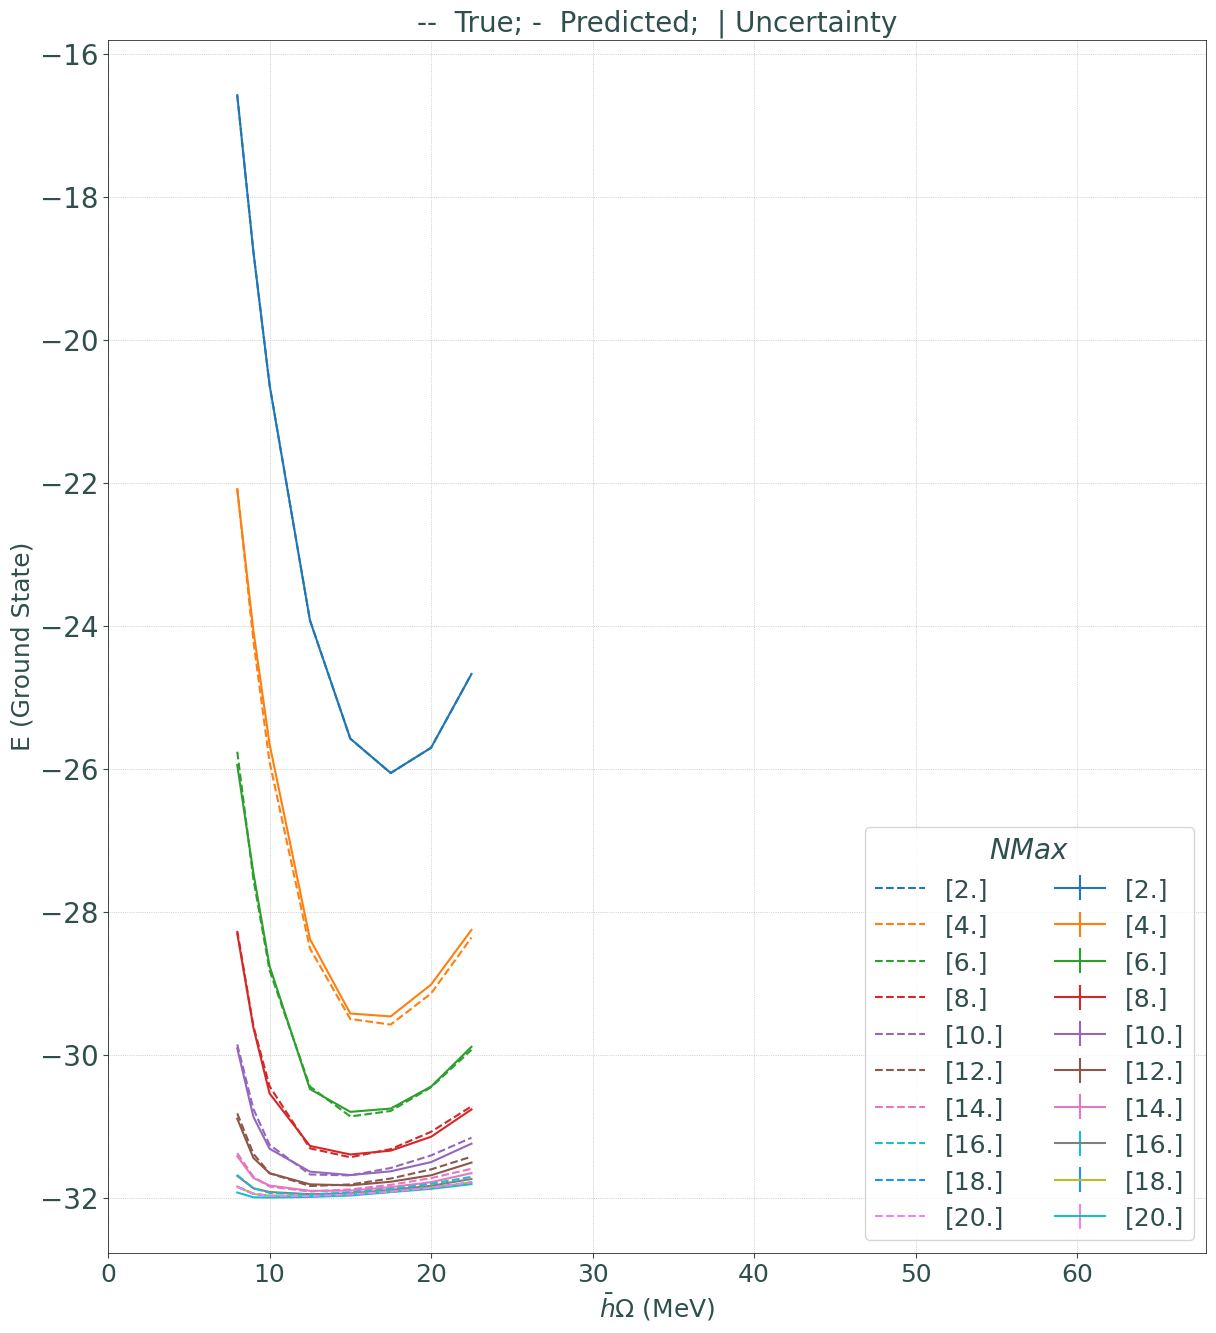

In [78]:
generate_plot_hbar_omega(f"Figures/plot_with_respect_hbaromega{hbaromega_choose}.pdf",\
            f"models/MLP__Extrapolation_vdist{hbaromega_choose}_",\
            list_models, x)